In [ ]:
!wget --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:87.0) Gecko/20100101 Firefox/87.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --header 'Upgrade-Insecure-Requests: 1' 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/5144/862050/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1619892031&Signature=sxJDQZjNgfv4NWB%2F2E%2FqUyCnRPdBylRoQ7Pe%2F%2FwaxoOfWPLuyScoCjNI82Mjdlhaj3XGogDpb4Vc5rdkW8cJlfYLBW69Y47hY0QRkIhEu06%2F5mf1qOKD%2BCQuH7AaDw2zpWNmbFfaDFuFKfShBOKG%2BBYjBIy90NLkVd7xsTEOsHake2RKgZeBN86fEILLcPNHhQserJ1ZCl4zuQ5pUoutKEJwcVpW%2FY1QXgtx4dtii46maBo4LexXjGfEiqzuC8hqy6q9N4vQHt4t3c3fP9O8P%2BZC5yf5LER2FKF%2FHC7CeB1DF4MhEUhbUihRGWr7NmFH%2FIox2qc%2BZfzcC7cXE4Qy1Q%3D%3D&response-content-disposition=attachment%3B+filename%3Dultrasound-nerve-segmentation.zip' --output-document 'ultrasound-nerve-segmentation.zip'
!pip install q keras==2.4.1
!pip install segmentation_models
!pip install tensorflow_io
!pip install tensorflow_model_optimization
!unzip '/content/ultrasound-nerve-segmentation.zip'

In [13]:
#Loading dependancies
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, KFold
import tensorflow_io as tfio
import keras
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate,Dropout
from tensorflow.keras.layers import Multiply, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model,save_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
import tensorflow
import keras
from sklearn.metrics import confusion_matrix
import cv2
import imgaug.augmenters as iaa
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
focal_loss = sm.losses.cce_dice_loss
import random
import segmentation_models as sm
from segmentation_models import Unet
import tempfile
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
def classifier_generator(images):
    '''Construct a data generator using tf.Dataset to load only images'''
    image_string=tf.io.read_file(images)
    image = tfio.experimental.image.decode_tiff(image_string)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image

In [ ]:
def train_generator(images,masks):
    '''Construct a data generator using tf.Dataset to load image+masks'''
    image_string=tf.io.read_file(images)
    image = tfio.experimental.image.decode_tiff(image_string)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    mask=tf.io.read_file(masks)
    mask = tfio.experimental.image.decode_tiff(mask)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [128, 128],method='nearest')
    return image,mask

In [ ]:
def iou_coef(y_true, y_pred, smooth=1):
  '''This function calculates iou '''
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
  union = K.sum(y_true,[1,2])+K.sum(y_pred,[1,2])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth))
  return iou.numpy()

In [14]:
#loading image df
img=pd.read_csv('/content/drive/MyDrive/dup_rem.csv')
df=pd.read_csv('/content/train_masks.csv')
img.drop('Unnamed: 0',axis=1,inplace=True)
img.image_name=img.image_name.astype(int)
img.subject_name=img.subject_name.astype(int)
img.columns=['image_path','img','subject','mask_path']
new_df=pd.merge(img,df,on=['img','subject'])
new_df.pixels.fillna(0,inplace=True)
val=[0 if i==0 else 1 for i in new_df.pixels]
new_df['mask_pres']=val
pos_df=new_df[new_df.mask_pres==1]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(new_df.image_path, new_df.mask_path, test_size=0.2, random_state=42)

Loading model weights

In [16]:
#loading the classifier model
model_clf = keras.models.load_model('/content/drive/MyDrive/classfier_nerve')

In [17]:
#loading the segmentor model
model=keras.models.load_model('/content/drive/MyDrive/segmetnor',custom_objects={'categorical_crossentropy_plus_dice_loss':focal_loss,'iou_score':iou_score})

Quantizing models

In [18]:
#quantizing classifier model
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/classfier_nerve')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quant_model_clf = converter.convert()
#quantizing segmentor model
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/segmetnor')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quant_model = converter.convert()

Saving quantized models as tflite file

In [19]:
#saving the tflite file of classifier quantized model
f = open("quant_classifier.tflite", "wb")
f.write(quant_model_clf)
f.close()
#saving the tflite file of segmentor quantized model
f = open("quant_segmentor.tflite", "wb")
f.write(quant_model)
f.close()

In [24]:
interpreter_clf = tf.lite.Interpreter(model_path="quant_classifier.tflite")
interpreter_clf.allocate_tensors()
interpreter_seg = tf.lite.Interpreter(model_path="quant_segmentor.tflite",num_threads=1)
interpreter_seg.allocate_tensors()

In [31]:
test_image = tf.expand_dims(x_tes, axis=0)
test_image=tf.cast(test_image,tf.float32)

input_index = interpreter_clf.get_input_details()[0]["index"]
output_index = interpreter_clf.get_output_details()[0]["index"]

# input_index = interpreter_seg.get_input_details()[0]["index"]
# output_index = interpreter_seg.get_output_details()[0]["index"]

# interpreter_seg.set_tensor(input_index, test_image)
# interpreter_seg.invoke()
# predictions = interpreter_seg.get_tensor(output_index)

Getting predictions using quantized classifier model

In [45]:
#Getting the prediction on validation set ofafter quantized model
scores_val=[]
X_tr=np.zeros((len(X_valid),128,128,4),dtype=np.float32)
y_tr=np.zeros((len(y_valid),128,128,4),dtype=np.float32)
pred_val=np.zeros((len(y_valid),128,128,4),dtype=np.float32)
for i in range(len(X_valid)):
  image_cl=classifier_generator(X_valid.iloc[i])
  image_cl=tf.expand_dims(image_cl,0)
  image_cl=tf.cast(image_cl,tf.float32)
  interpreter_clf.set_tensor(input_index, image_cl)
  interpreter_clf.invoke()
  pred_clf = interpreter_clf.get_tensor(output_index)
  if pred_clf>=0.4:
    X_tr[i],y_tr[i]=train_generator(X_valid.iloc[i],y_valid.iloc[i])
    pred_seg=model.predict(tf.expand_dims(X_tr[i],0))
    pred_val[i]=pred_seg
    true=tf.expand_dims(y_tr[i],0)
    score=iou_coef(true,pred_seg)
    scores_val.append(score)
  else:
    X_tr[i],y_tr[i]=train_generator(X_valid.iloc[i],y_valid.iloc[i])
    pred_seg=np.zeros((1,128,128,4),dtype=np.float32)
    pred_val[i]=pred_seg
    true=tf.expand_dims(y_tr[i],0)
    score=iou_coef(true,pred_seg)
    scores_val.append(score)

Prediction

In [37]:
#Getting the prediction on validation set of before quantized model
scores_val_b=[]
X_tr=np.zeros((len(X_valid),128,128,4),dtype=np.float32)
y_tr=np.zeros((len(y_valid),128,128,4),dtype=np.float32)
pred_val_b=np.zeros((len(y_valid),128,128,4),dtype=np.float32)
for i in range(len(X_valid)):
  image_cl=classifier_generator(X_valid.iloc[i])
  image_cl=tf.expand_dims(image_cl,0)
  pred_clf=model_clf.predict(image_cl)
  if pred_clf>=0.4:
    X_tr[i],y_tr[i]=train_generator(X_valid.iloc[i],y_valid.iloc[i])
    pred_seg=model.predict(tf.expand_dims(X_tr[i],0))
    pred_val_b[i]=pred_seg
    true=tf.expand_dims(y_tr[i],0)
    score=iou_coef(true,pred_seg)
    scores_val_b.append(score)
  else:
    X_tr[i],y_tr[i]=train_generator(X_valid.iloc[i],y_valid.iloc[i])
    pred_seg=np.zeros((1,128,128,4),dtype=np.float32)
    pred_val_b[i]=pred_seg
    true=tf.expand_dims(y_tr[i],0)
    score=iou_coef(true,pred_seg)
    scores_val_b.append(score)

In [51]:
print('Mean validation score before quantization= ',np.mean(scores_val_b))
print('Mean validation score after quantization= ',np.mean(scores_val))

Mean validation score before quantization= 0.62266594
Mean validation score after quantization= 0.60848292


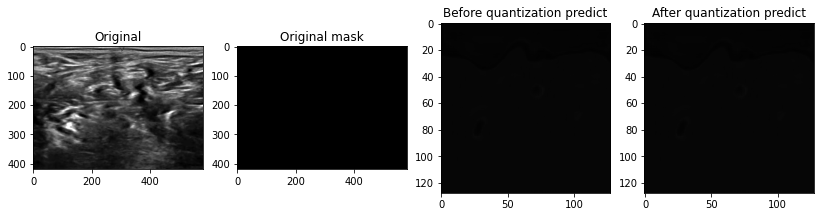

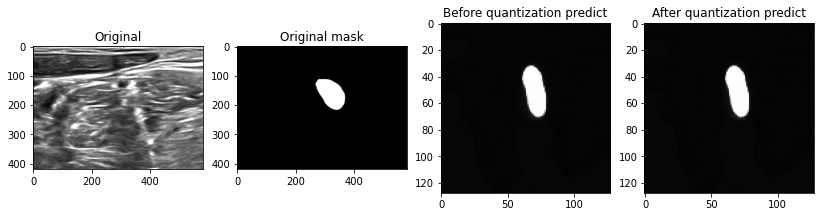

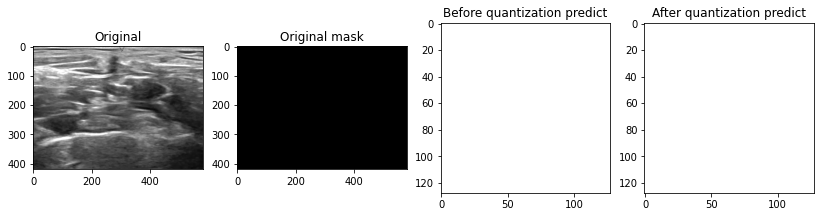

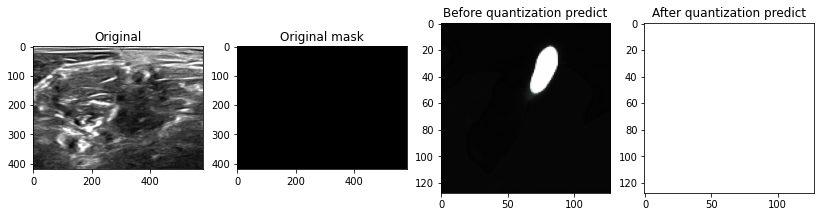

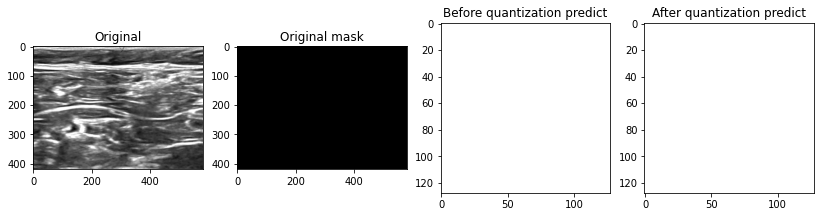

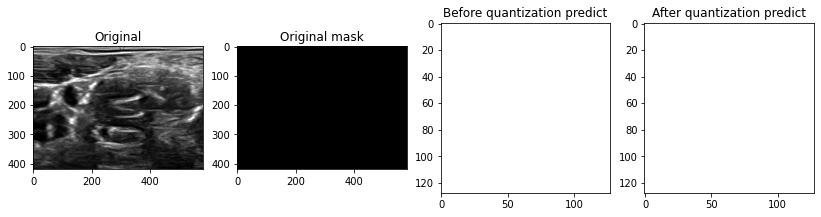

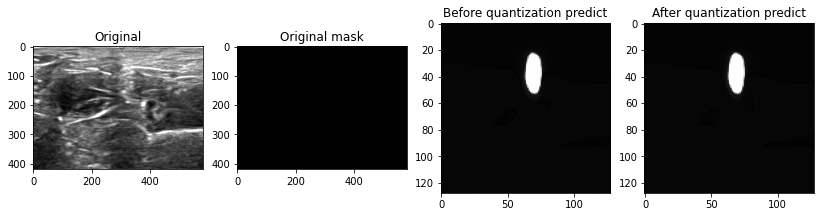

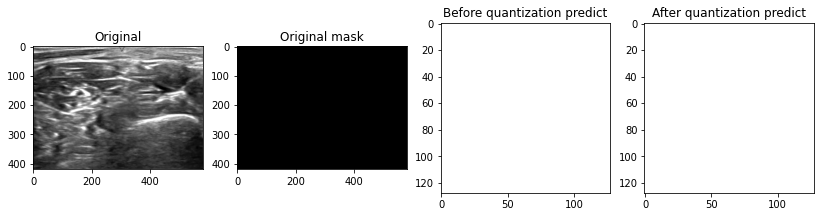

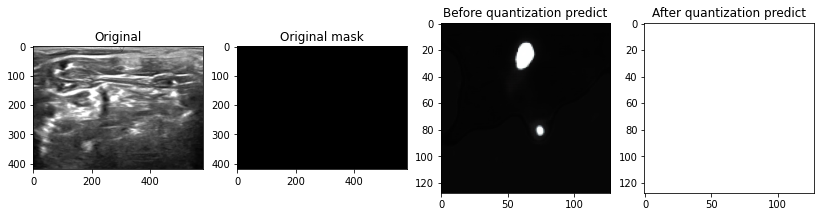

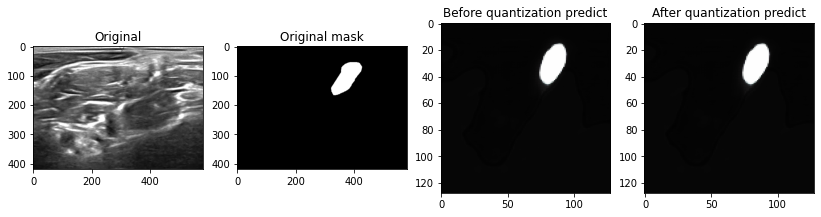

In [76]:
random_gen=[i for i in range(1080)]
for j in range(10):
  i=random.choice(random_gen)
  fig,ax=plt.subplots(1,4,figsize=(14,7))
  quer=classifier_generator(X_valid.iloc[i])
  ax[0].imshow(cv2.imread(X_valid.iloc[i],cv2.IMREAD_GRAYSCALE),cmap='gray')
  ax[0].set_title('Original')
  ax[1].imshow(cv2.imread(y_valid.iloc[i],cv2.IMREAD_GRAYSCALE),cmap='gray')
  ax[1].set_title('Original mask')
  ax[2].imshow(pred_val_b[i])
  ax[2].set_title('Before quantization predict')
  ax[3].imshow(pred_val[i])
  ax[3].set_title('After quantization predict')

In [ ]:
# https://www.geeksforgeeks.org/how-to-get-size-of-folder-using-python/
size = 0
# assign folder path
Folderpath = '/content/drive/MyDrive/classfier_nerve'  
# get size
for path, dirs, files in os.walk(Folderpath):
    for f in files:
        fp = os.path.join(path, f)
        size += os.path.getsize(fp)
  
# display size
print("Pre quantization model size= " + str(size/(1024*1024)),'MB')

Pre quantization model size= 248.4090223312378 MB


In [ ]:
# https://www.geeksforgeeks.org/how-to-get-size-of-folder-using-python/
size = 0
# assign folder path
Folderpath = '/content/drive/MyDrive/segmentor_nerve'  
# get size
for path, dirs, files in os.walk(Folderpath):
    for f in files:
        fp = os.path.join(path, f)
        size += os.path.getsize(fp)
  
# display size
print("Pre quantization model size= " + str(size/(1024*1024)),'MB')

Pre quantization model size= 127.00345516204834 MB


In [ ]:
print('Post quantization model size =',os.stat('quant_classifier.tflite').st_size/(1024*1024),'MB')

Post quantization model size = 59.54229736328125 MB


In [ ]:
print('Post quantization model size =',os.stat('quant_segmentor.tflite').st_size/(1024*1024),'MB')

Post quantization model size = 60.416900634765625 MB


In [50]:
print('Reduction in classifier model size = {0:.1f} x'.format(248.40902/59.54229))
print('Reduction in segmentation model size = {0:.1f} x'.format(127.003455/60.41690))

Reduction in classifier model size = 4.2 x
Reduction in segmentation model size = 2.1 x


In [73]:
print('Reduction in validation iou score = {0:.3f}'.format(0.62266594-0.60848292))

Reduction in validation iou score = 0.014
